In [339]:
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
import numpy as np
import pandas as pd

import re
import pickle
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, make_scorer
from vowpalwabbit.sklearn_vw import VWClassifier, VW
import itertools
from sklearn.decomposition import NMF, TruncatedSVD

In [343]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from scipy.sparse import csr_matrix, hstack

In [342]:
import matplotlib.pyplot as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [344]:
def sparsematrix(X):
    row = []
    col = []
    data = []
    for r in range(X.shape[0]):
        row_counter = Counter(X[r])
        for site, num in row_counter.items():
            row.append(r)
            col.append(site)
            data.append(num)
    print "Sparse Matrix - rows:", X.shape[0], "columns:", len(set(col))
    return csr_matrix((data, (row, col)), shape=(X.shape[0], len(set(col))))[:,1:]


def sites_to_sparse_tfidf(train_data, test_data, target_col, session_length, label_encoder=False):
    train_test_df = pd.concat([train_data, test_data])
    #train_index_full = list(train_data.index)
    #train_index_dup = list(train_data[train_data.duplicated(subset=['site' + str(c) for c in range(1,10+1)])]\
                           #[['site' + str(c) for c in range(1,10+1)]+["target"]].index)

    y = train_data[target_col]

    train_test_df_sites = train_test_df[['site' + str(c) for c in range(1,10+1)]].fillna(0).astype('int')
    train_test_df_sites_array = [" ".join(["s_"+str(s) for s in train_test_df_sites.as_matrix()[i] if int(s) != 0]) \
                                                                  for i in range(train_test_df_sites.shape[0])]

    tfidf = TfidfVectorizer(max_df=0.9).fit(train_test_df_sites_array) #TfidfVectorizer()
    X_train_test_sparse = tfidf.transform(train_test_df_sites_array)

    X_train_sparse = X_train_test_sparse[:len(train_data)]
    X_test_sparse = X_train_test_sparse[len(train_data):]
    
    sites_columns_num = X_train_test_sparse.shape[1]
    
    y_for_vw = None
    class_encoder = None
    if label_encoder:
        class_encoder = LabelEncoder().fit(y.astype('str'))
        y_for_vw = class_encoder.transform(y.astype('str')) + 1
    
    return [X_train_sparse, X_test_sparse, y, y_for_vw, sites_columns_num, class_encoder, tfidf]


def features_to_sparse(train_data, test_data, feature_cols):
    features_matrix = []
    for df in [train_data, test_data]:
        num_cols = 0
        data = []
        rows = []
        cols = []
        for label in feature_cols:
            if label in ["day_of_week", "daytime"]:
                coldata = list(df[[label]].values.T[0].astype('float') + 1)
            else:
                coldata = list(df[[label]].values.T[0].astype('float'))
            if len(data):
                data += coldata
            else:
                data = list(coldata)
            if len(cols):
                cols += [num_cols] * len(coldata)
            else:
                cols = [num_cols] * len(coldata)
            num_cols += 1
        rows = [r for r in range(df.shape[0])] * num_cols
        features = csr_matrix((data, (rows, cols)), shape=(df.shape[0], num_cols), dtype=float)
        features_matrix.append(features)
    return features_matrix


def calc_site_times_portions(train_data, test_data):
    site_times = [{},{}]
    count = 0
    for data in [train_data, test_data]:
        for r, row in data[:][range(0, 10)+range(20,30)].iterrows():
            rowdic = {}
            for c, s in [[c, 'site' + str(c)] for c in range(1,10)]:
                if row[s] == 0:
                    continue
                if row[s] in rowdic:
                    rowdic[int(row[s])] += row["time_diff"+str(c)]
                else:
                    rowdic[int(row[s])] = row["time_diff"+str(c)]
            site_times[count][r] = {}
            for site, time in rowdic.items():
                if len(rowdic) == 1:
                    site_times[count][r][int(site)] = 1.0
                    continue
                if time > 0:
                    site_times[count][r][int(site)] = round(float(time)/row["session_timespan"],3)
        count+=1
    return site_times

def site_times_to_sparse(sitetimes):
    row = []
    col = []
    data = []
    rowcount = 0
    for sitetime in sitetimes:
        for r, sites in sitetime.items():
            for site, p in sites.items():
                col.append(site)
                row.append(rowcount)
                data.append(p)
            rowcount+=1
    site_times_sparse = csr_matrix((data, (row, col)), shape=(len(sitetimes[0])+len(sitetimes[1]), max(col)+1), \
                                                                                              dtype=float)[:,1:]
    return site_times_sparse



def combine_sites_features_sparse(sites_train_sparse, features_train_sparse, \
                                  sites_test_sparse, features_test_sparse, \
                                  train_duplicates_mask, test_duplicates_mask, \
                                  train_site_times_sparse = None, test_site_times_sparse = None):
    if train_site_times_sparse is not None and test_site_times_sparse is not None:
        X_train_sparse = hstack([sites_train_sparse, features_train_sparse, train_site_times_sparse], dtype=float).tocsr()
        X_test_sparse = hstack([sites_test_sparse, features_test_sparse, test_site_times_sparse], dtype=float).tocsr()
    else:
        X_train_sparse = hstack([sites_train_sparse, features_train_sparse], dtype=float).tocsr()
        X_test_sparse = hstack([sites_test_sparse, features_test_sparse], dtype=float).tocsr()
        
    X_train_sparse = hstack([X_train_sparse, train_duplicates_mask], dtype=float).tocsr()
    X_test_sparse = hstack([X_test_sparse, test_duplicates_mask], dtype=float).tocsr() 
    return [X_train_sparse, X_test_sparse]


def sparse_matrix_to_vw(X_sparse_full, sites_columns_num, vocabulary, y=None, mark_duplicates=False):
    sessions = {}
    used = {}
    prediction = {}
    day_of_week = {}
    start_hour = {}
    daytime = {}
    unique_sites = {}
    top30_portion = {}
    fb_portion = {}
    youtube_portion = {}
    bot30_portion = {}
    site_longest_time = {}
    session_timespan = {}
    sitetimes = {}
    
    add_features = True
    X_sparse = X_sparse_full[:,:-1]

    for r, c in zip(X_sparse.nonzero()[0], X_sparse.nonzero()[1]):
        if tuple([r,c]) not in used:
            used[tuple([r, c])] = 1
            if add_features:
                if c == X_sparse.shape[1] - len(mycolumns) - sites_columns_num + mycolumns.index("prediction"):
                    prediction[r] = " |aprediction {}:{}".format(int(X_sparse[r,c]), 100)
                    #prediction[r] = " |prediction:100 {}".format(int(X_sparse[r,c]))
                    continue
                elif c == X_sparse.shape[1] - len(mycolumns) - sites_columns_num + mycolumns.index("day_of_week"):
                    day_of_week[r] = " |bday_of_week {}".format(int(X_sparse[r,c]))
                    #day_of_week[r] = " day_of_week:{}".format(int(X_sparse[r,c]))
                    continue
                elif c == X_sparse.shape[1] - len(mycolumns) - sites_columns_num + mycolumns.index("start_hour"):
                    start_hour[r] = " |chour_start {}".format(int(X_sparse[r,c]))
                    #start_hour[r] = " start_hour:{}".format(int(X_sparse[r,c]))
                    continue
                elif c == X_sparse.shape[1] - len(mycolumns) - sites_columns_num + mycolumns.index("daytime"):
                    daytime[r] = " |dtime_of_day {}".format(int(X_sparse[r,c]))
                    #daytime[r] = " daytime:{}".format(int(X_sparse[r,c]))
                    continue
                elif c == X_sparse.shape[1] - len(mycolumns) - sites_columns_num + mycolumns.index("session_timespan"):
                    session_timespan[r] = " session_timespan:{}".format(int(X_sparse[r,c]))
                    #session_timespan[r] = " session_timespan:{}".format(int(X_sparse[r,c]))
                    continue
                elif c == X_sparse.shape[1] - len(mycolumns) - sites_columns_num + mycolumns.index("#unique_sites"):
                    unique_sites[r] = " unique_sites:{}".format(int(X_sparse[r,c]))
                    #unique_sites[r] = " unique_sites:{}".format(X_sparse[r,c])
                    continue
                elif c == X_sparse.shape[1] - len(mycolumns) - sites_columns_num + mycolumns.index("site_longest_time"):
                    site_longest_time[r] = " |hsite_longest_time {}:{}".format(int(X_sparse[r,c]), 3)
                    #site_longest_time[r] = " site_longest_time:{}".format(int(X_sparse[r,c]))
                    continue
                elif c == X_sparse.shape[1] - len(mycolumns) - sites_columns_num + mycolumns.index("top30_portion"):
                    top30_portion[r] = " top30:{}".format(X_sparse[r,c])
                    continue
                elif c == X_sparse.shape[1] - len(mycolumns) - sites_columns_num + mycolumns.index("bot30_portion"):
                    bot30_portion[r] = " bot30:{}".format(X_sparse[r,c])
                    continue
                elif c == X_sparse.shape[1] - len(mycolumns) - sites_columns_num + mycolumns.index("fb_portion"):
                    fb_portion[r] = " facebook:{}".format(X_sparse[r,c])
                    continue
                elif c == X_sparse.shape[1] - len(mycolumns) - sites_columns_num + mycolumns.index("youtube_portion"):
                    youtube_portion[r] = " youtube:{}".format(X_sparse[r,c])
                    continue
            if c < sites_columns_num: #X_sparse.shape[1] - len(mycolumns): 
                if r in sessions:
                    sessions[r] += " {}:{}".format(int(vocabulary[c]), X_sparse[r,c])
                else:
                    if y is not None:
                        if int(X_sparse_full[r, -1]) and mark_duplicates: # duplicate row indicator
                            sessions[r] = str(y[r]) + ' 0.3' + ' |site' + " {}:{}".format(int(vocabulary[c]), X_sparse[r,c])
                        else:
                            sessions[r] = str(y[r]) + ' |site' + " {}:{}".format(int(vocabulary[c]), X_sparse[r,c])
                    else:
                        sessions[r] = ' |site' + " {}:{}".format(int(vocabulary[c]), X_sparse[r,c])
            elif c > X_sparse.shape[1] - sites_columns_num:
                if r in sitetimes:
                    sitetimes[r] += " {}:{}".format(int(c - sites_columns_num - len(mycolumns)+1), float(X_sparse[r,c]))
                else:
                    sitetimes[r] = ' |isitetime' + " {}:{}".format(int(c - sites_columns_num - len(mycolumns)+1), float(X_sparse[r,c]))
        
    
    return {"sites": sessions, "prediction": prediction, "day_of_week": day_of_week, \
                      "start_hour": start_hour, "daytime": daytime, \
                     "unique_site": unique_sites, "top30_portion": top30_portion, \
                    "bot30_portion": bot30_portion, "fb_portion": fb_portion, \
                    "youtube_portion": youtube_portion, "site_longest_time": site_longest_time, \
                    "session_timespan": session_timespan, "sitetimes": sitetimes}



def vw_to_file(sites, out_file, features={}, quiet=True):   
    vw_writer = open(out_file, 'w')
    final_vw = {}
    gen_features = []
    
    if not quiet:
        print "Features:", features.keys()
        
    for r in sorted(sites.keys()):
        final_vw[r] = sites[r] #+ " |features"
        for fname, feature in features.items():
            if fname in ["youtube_portion", "fb_portion", "top30_portion", "bot30_portion", \
                                         "unique_sites", "session_timespan"] and r in feature:
                gen_features.append(feature[r])
                continue
            if r in feature:
                final_vw[r] += feature[r]        
            
        if len(gen_features):
            final_vw[r] += " |features"
            for gf in gen_features:
                final_vw[r] += gf
        gen_features = []
        
        #if "prediction" in features and r in features["prediction"]:
            #final_vw[r] += features["prediction"][r]
        
        vw_writer.write(final_vw[r] + "\n")
        
    vw_writer.close()
    
    
def write_to_submission_file(predicted_labels, out_file,
                             target='user_id', index_label="session_id"):
    # turn predictions into data frame and save as csv file
    predicted_df = pd.DataFrame(predicted_labels,
                                index = np.arange(1, predicted_labels.shape[0] + 1),
                                columns=[target])
    predicted_df.to_csv(out_file, index_label=index_label)



In [335]:
def text_classifier(vectorizer, transformer, classifier):
    return Pipeline(
            [("vectorizer", vectorizer),
            ("transformer", transformer),
            ("classifier", classifier)]
        )

In [336]:
clf_pipeline = Pipeline(
            [("vectorizer", TfidfVectorizer()),
            ("classifier", LinearSVC())]
        )

# Let's Start

In [345]:
train_data = pd.read_csv('kaggle_data/full_train_w5_new.csv')

test_data = pd.read_csv('kaggle_data/full_test.csv')

In [346]:
%%time
# Additionally, let's calculate the percentage of session time spent by every site in session
site_times = calc_site_times_portions(train_data, test_data)

CPU times: user 1min 21s, sys: 612 ms, total: 1min 21s
Wall time: 1min 21s


In [347]:
# Convert site times to sparse format
site_times_sparse = site_times_to_sparse(site_times)
train_site_times_sparse = site_times_sparse[:len(train_data)]
test_site_times_sparse = site_times_sparse[len(train_data):]
train_site_times_sparse

<171492x24052 sparse matrix of type '<type 'numpy.float64'>'
	with 599088 stored elements in Compressed Sparse Row format>

In [348]:
train_test_df = pd.concat([train_data, test_data])

session_length = 10

train_index_full = list(train_data.index)
train_index_dup = list(train_data[train_data.duplicated(subset=['site' + str(c) for c in range(1,session_length+1)], keep=False)]\
                       [['site' + str(c) for c in range(1,10+1)]+["target"]].index)
test_index_full = list(test_data.index)
test_index_dup = list(test_data[test_data.duplicated(subset=['site' + str(c) for c in range(1,session_length+1)], keep=False)]\
                       [['site' + str(c) for c in range(1,10+1)]].index)
train_duplicates_mask = np.transpose([np.in1d(train_index_full, train_index_dup).astype(int)])
test_duplicates_mask = np.transpose([np.in1d(test_index_full, test_index_dup).astype(int)])

y = train_data["target"]

train_test_df_sites = train_test_df[['site' + str(c) for c in range(1,10+1)]].fillna(0).astype('int')
train_test_df_sites_array = [" ".join(["s_"+str(s) for s in train_test_df_sites.as_matrix()[i] if int(s) != 0]) \
                                                              for i in range(train_test_df_sites.shape[0])]

tfidf = TfidfVectorizer(analyzer=str.split, max_df=0.9, ngram_range=(1,3)).fit(train_test_df_sites_array) #TfidfVectorizer()
X_train_test_sparse = tfidf.transform(train_test_df_sites_array)
#X_train_test_sparse = TruncatedSVD(n_components=10000).fit_transform(X_train_test_sparse)

X_train_sparse = X_train_test_sparse[:len(train_data)]
X_test_sparse = X_train_test_sparse[len(train_data):]

class_encoder = LabelEncoder().fit(y.astype('str'))
y_for_vw = class_encoder.transform(y.astype('str')) + 1

sites_columns_num = X_train_test_sparse.shape[1]
inv_vocabulary = {v: int(re.search("s_(\d+)$", k).group(1)) for k, v in tfidf.vocabulary_.iteritems()}

In [349]:
%%time
#X_train_sparse, X_test_sparse, y, y_for_vw, sites_columns_num, class_encoder, tfidf = \
    #sites_to_sparse_tfidf(train_data, test_data, "target", 10, label_encoder=LabelEncoder())

mycolumns = [label for label in test_data[range(20, test_data.shape[1])]]

train_features, test_features = features_to_sparse(train_data, test_data, mycolumns)

X_train_sparse, X_test_sparse = combine_sites_features_sparse(X_train_sparse, train_features, \
                                                             X_test_sparse, test_features, \
                                                              train_duplicates_mask, test_duplicates_mask,
                                                              train_site_times_sparse, test_site_times_sparse)

X_train, X_valid, y_train, y_valid = train_test_split(X_train_sparse, y_for_vw, test_size=0.3, stratify=y_for_vw)

CPU times: user 4.29 s, sys: 188 ms, total: 4.48 s
Wall time: 4.48 s


In [352]:
%%time
train_part_vw = sparse_matrix_to_vw(X_train, sites_columns_num, inv_vocabulary, y_train, mark_duplicates=False)
valid_vw = sparse_matrix_to_vw(X_valid, sites_columns_num, inv_vocabulary, y_valid)
train_vw = sparse_matrix_to_vw(X_train_sparse, sites_columns_num, inv_vocabulary, y_for_vw, mark_duplicates=False)
test_vw = sparse_matrix_to_vw(X_test_sparse, sites_columns_num, inv_vocabulary)

CPU times: user 7min 55s, sys: 492 ms, total: 7min 55s
Wall time: 7min 56s


In [353]:
for k in train_vw.keys():
    print k, len(train_vw[k])

youtube_portion 9598
site_longest_time 171492
top30_portion 121483
sitetimes 170182
unique_site 171492
start_hour 171492
prediction 36320
session_timespan 168514
day_of_week 171492
bot30_portion 66716
fb_portion 22775
sites 171492
daytime 171492


In [354]:
keys = [
   'day_of_week',
   'daytime',
   'prediction',
   'start_hour',
   'youtube_portion', 'fb_portion', 'sitetimes']

vw_to_file(train_part_vw["sites"], 'kaggle_data/train_part_tfidf.vw', features={x:train_part_vw[x] for x in keys}, quiet=False)
vw_to_file(valid_vw["sites"], 'kaggle_data/valid_tfidf.vw', features={x:valid_vw[x] for x in keys}, quiet=False)
vw_to_file(train_vw["sites"], 'kaggle_data/train_tfidf.vw', features={x:train_vw[x] for x in keys}, quiet=False)
vw_to_file(test_vw["sites"], 'kaggle_data/test_tfidf.vw', features={x:test_vw[x] for x in keys}, quiet=False)


Features: ['youtube_portion', 'sitetimes', 'fb_portion', 'start_hour', 'prediction', 'daytime', 'day_of_week']
Features: ['youtube_portion', 'sitetimes', 'fb_portion', 'start_hour', 'prediction', 'daytime', 'day_of_week']
Features: ['youtube_portion', 'sitetimes', 'fb_portion', 'start_hour', 'prediction', 'daytime', 'day_of_week']
Features: ['youtube_portion', 'sitetimes', 'fb_portion', 'start_hour', 'prediction', 'daytime', 'day_of_week']


In [355]:
with open("kaggle_data/train_part_tfidf.vw") as f:
    train_part_file = f.readlines()

with open("kaggle_data/train_tfidf.vw") as f:
    train_file = f.readlines()

with open("kaggle_data/valid_tfidf.vw") as f:
    valid_file = f.readlines()

with open("kaggle_data/test_tfidf.vw") as f:
    test_file = f.readlines()

In [52]:
len(train_part_file)

125118

In [53]:
len(train_part_file)

125118

In [54]:
skf = StratifiedKFold(n_splits=3, shuffle=True)

%%time
model = VW(oaa=550, passes=30, b=26, convert_to_vw=False, decay_learning_rate=0.8097261737051064, random_seed=7, \
           initial_t=4.617634843743026e-05, l=0.9037695975303308, power_t=0.5, l2=3.022731250666471e-11, \
           loss_function='logistic', l1=1.2144958188964683e-11, cubic="sbc", sort_features=True, q="sd", noconstant=True)

c_scores = cross_val_score(model, X=train_part_file, y=y_train, cv=skf, scoring=make_scorer(accuracy_score), n_jobs=3)
print c_scores, np.mean(c_scores)

In [359]:
%%time
!vw --oaa=550 -d kaggle_data/train_part_tfidf.vw --passes=20 \
-f kaggle_data/initial_model_idf.vw -b 26 -c -k \
--decay_learning_rate 0.8097261737051064 \
--initial_t 4.617634843743026e-05 -l 0.3037695975303308 --power_t 0.5 --l2=1e-9 \
--loss_function='logistic' --l1=1.2144958188964683e-10 --cubic="sbc" --sort_features -q "bs" \
--stage_poly --batch_sz 20007 --batch_sz_no_doubling

creating quadratic features for pairs: bs 
creating cubic features for triples: sbc 
using l1 regularization = 1.2145e-10
using l2 regularization = 1e-09
final_regressor = kaggle_data/initial_model_idf.vw
Num weight bits = 26
learning rate = 0.30377
initial_t = 4.61763e-05
power_t = 0.5
decay_learning_rate = 0.809726
creating cache_file = kaggle_data/train_part_tfidf.vw.cache
Reading datafile = kaggle_data/train_part_tfidf.vw
num sources = 1
average  since         example        example  current  current  current
loss     last          counter         weight    label  predict features
1.000000 1.000000            1            1.0      244        1       15
1.000000 1.000000            2            2.0      113      244       39
1.000000 1.000000            4            4.0      215      244       16
1.000000 1.000000            8            8.0      168      150       19
1.000000 1.000000           16           16.0      145      244       32
0.968750 0.937500           32           32

average loss = 0.349300 h

In [357]:
%%time
!vw -i kaggle_data/initial_model_idf.vw  -t -d kaggle_data/valid_tfidf.vw \
-p kaggle_data/vw_valid_pred_idf.csv --quiet

CPU times: user 308 ms, sys: 68 ms, total: 376 ms
Wall time: 18 s


In [358]:
vw_valid_pred = pd.read_csv("kaggle_data/vw_valid_pred_idf.csv", header=None)
accuracy_score(y_valid, vw_valid_pred.values)

0.64750816358264651

Valid: 0.64750816358264651

### Submission

In [298]:
trainvw = open("kaggle_data/train_tfidf.vw").readlines()
np.random.shuffle(trainvw)
with open("kaggle_data/train_tfidf.vw", "wb") as f:
    for item in trainvw:
        f.write("%s" % item)

In [299]:
%%time
!vw --oaa=550 -d kaggle_data/train_tfidf.vw --passes=30 \
-f kaggle_data/initial_model_idf.vw -b 26 -c -k \
--decay_learning_rate 0.9318314904142921 \
--initial_t 0.002413156753380314 -l 2.650131758316566 --power_t 0.5 \
--loss_function='hinge' --l1=1.7527679278563712e-08 --l2=7.742609589493446e-08 \
--cubic="sbc" --sort_features -q "sc" \
--stage_poly --batch_sz {len(train_file)/6} --batch_sz_no_doubling

creating quadratic features for pairs: sc 
creating cubic features for triples: sbc 
using l1 regularization = 1.75277e-08
using l2 regularization = 7.74261e-08
final_regressor = kaggle_data/initial_model_idf.vw
Num weight bits = 26
learning rate = 2.65013
initial_t = 0.00241316
power_t = 0.5
decay_learning_rate = 0.931831
creating cache_file = kaggle_data/train_tfidf.vw.cache
Reading datafile = kaggle_data/train_tfidf.vw
num sources = 1
average  since         example        example  current  current  current
loss     last          counter         weight    label  predict features
1.000000 1.000000            1            1.0       31        1       12
1.000000 1.000000            2            2.0      189       31       29
1.000000 1.000000            4            4.0      318       31       29
1.000000 1.000000            9            8.3      423       35       24
0.942197 0.888889           18           17.3       57      227       26
0.971671 1.000000           36           35.3  

In [300]:
%%time
!vw -i kaggle_data/initial_model_idf.vw -t -d kaggle_data/test_tfidf.vw \
-p kaggle_data/vw_test_pred_idf.csv

creating quadratic features for pairs: sc 
creating cubic features for triples: sbc 
only testing
predictions = kaggle_data/vw_test_pred_idf.csv
Num weight bits = 26
learning rate = 0.5
initial_t = 0
power_t = 0.5
using no cache
Reading datafile = kaggle_data/test_tfidf.vw
num sources = 1
average  since         example        example  current  current  current
loss     last          counter         weight    label  predict features
1.000000 1.000000            1            1.0  unknown       69        8
1.000000 1.000000            2            2.0  unknown      517       28
1.000000 1.000000            4            4.0  unknown      168        8
1.000000 1.000000            8            8.0  unknown       24       34
1.000000 1.000000           16           16.0  unknown      328       16
1.000000 1.000000           32           32.0  unknown      460       31
1.000000 1.000000           64           64.0  unknown      296       31
1.000000 1.000000          128          128.0  unknow

In [301]:
vw_pred = pd.read_csv("kaggle_data/vw_test_pred_idf.csv", header=None)
vw_subm = class_encoder.inverse_transform(vw_pred-1)

In [302]:
write_to_submission_file(vw_subm,
                         'kaggle_data/22vw_submission_idf.csv')

Test: 0.53279

# Hyperopt

In [216]:
%%time
def hyperopt_train_test(params):
    with open("kaggle_data/train_part_tfidf.vw") as f:
        train_part_file = f.readlines()
    
    with open("kaggle_data/valid_tfidf.vw") as f:
        valid_file = f.readlines()
    
    model = VW(oaa=550, passes=30, b=26, convert_to_vw=False, **params)
    #skf = StratifiedKFold(n_splits=3, shuffle=True)
    model.fit(train_part_file)
    accuracy = accuracy_score(y_valid, model.predict(valid_file))
    return accuracy
    #return cross_val_score(model, X=train_part_file, y=y_train, cv=skf, scoring=make_scorer(accuracy_score), n_jobs=3).mean()

space4knn = {
    'l': hp.loguniform('l', -5, 3),
    'initial_t': hp.loguniform('initial_t', -10, 1),
    'power_t': hp.choice('power_t', [0.5, 1]),
    'decay_learning_rate': hp.uniform('decay_learning_rate', 0.001, 1),
    'l2': hp.loguniform('l2', -18, -9),
    'l1': hp.loguniform('l1', -18, -9),
    'loss_function': hp.choice('loss_function', ["logistic", "hinge"]),
    'sort_features': hp.choice('sort_features', [True]),
    'ftrl': hp.choice('ftrl', [True, False]),
    'noconstant': hp.choice('noconstant', [True, False]),
    'cubic': hp.choice('cubic', ['sbc', 'ibc']),
    'q': hp.choice('q', ["sb", "sc", "sd", "si"])
}

def f(params):
    print "Testing with params:"
    print params
    acc = hyperopt_train_test(params)
    print "Accuracy:", acc, "\n"
    return {'loss': -acc, 'status': STATUS_OK}

trials_wide_range = Trials()
#trials_wide_range = MongoTrials('mongo://localhost:1234/mydb/jobs', exp_key='exp1')
best = fmin(f, space4knn, algo=tpe.suggest, max_evals=50, trials=trials_wide_range)
print 'best:'
print best

Testing with params:
{'cubic': 'ibc', 'ftrl': False, 'decay_learning_rate': 0.15341532137608235, 'initial_t': 0.0023950875045329533, 'l': 15.956047017665702, 'q': 'sc', 'power_t': 0.5, 'noconstant': True, 'l2': 3.1159800720391363e-06, 'loss_function': 'logistic', 'l1': 4.033641574122989e-08, 'sort_features': True}
Accuracy: 0.0688656507542 

Testing with params:
{'cubic': 'ibc', 'ftrl': True, 'decay_learning_rate': 0.6663375737519568, 'initial_t': 1.1002656231826977, 'l': 1.2715486730828787, 'q': 'sc', 'power_t': 1, 'noconstant': True, 'l2': 7.311855640729857e-06, 'loss_function': 'logistic', 'l1': 5.5079864352026496e-05, 'sort_features': True}
Accuracy: 0.392493391385 

Testing with params:
{'cubic': 'ibc', 'ftrl': False, 'decay_learning_rate': 0.3827932478851185, 'initial_t': 0.027706171029664762, 'l': 0.059396568297389506, 'q': 'sd', 'power_t': 0.5, 'noconstant': False, 'l2': 8.509792857504779e-05, 'loss_function': 'logistic', 'l1': 6.756020485467812e-08, 'sort_features': True}
Accu

In [228]:
trials_wide_range.best_trial

{'book_time': datetime.datetime(2017, 1, 4, 5, 7, 53, 856000),
 'exp_key': None,
 'misc': {'cmd': ('domain_attachment', 'FMinIter_Domain'),
  'idxs': {'cubic': [37],
   'decay_learning_rate': [37],
   'ftrl': [37],
   'initial_t': [37],
   'l': [37],
   'l1': [37],
   'l2': [37],
   'loss_function': [37],
   'noconstant': [37],
   'power_t': [37],
   'q': [37],
   'sort_features': [37]},
  'tid': 37,
  'vals': {'cubic': [0],
   'decay_learning_rate': [0.9318314904142921],
   'ftrl': [1],
   'initial_t': [0.002413156753380314],
   'l': [2.650131758316566],
   'l1': [1.7527679278563712e-08],
   'l2': [7.742609589493446e-08],
   'loss_function': [1],
   'noconstant': [1],
   'power_t': [0],
   'q': [1],
   'sort_features': [0]},
  'workdir': None},
 'owner': None,
 'refresh_time': datetime.datetime(2017, 1, 4, 5, 12, 17, 482000),
 'result': {'loss': -0.6480329653242108, 'status': 'ok'},
 'spec': None,
 'state': 2,
 'tid': 37,
 'version': 0}

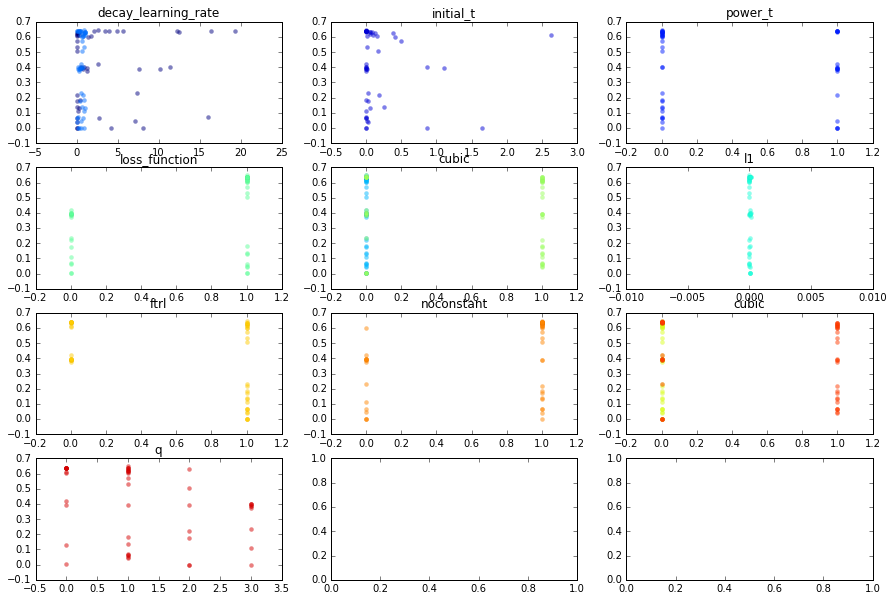

In [227]:
parameters = ['l', 'initial_t', 'power_t', 'decay_learning_rate', 'l2', 'l1', 'loss_function', 'cubic', \
             'sort_features', 'ftrl', 'noconstant', 'q']
cols = len(parameters)
f, axes = plt.subplots(nrows=5, ncols=3, figsize=(15,10))
cmap = plt.cm.jet
for i, val in enumerate(parameters):
    #print i, val
    xs = np.array([t['misc']['vals'][val] for t in trials_wide_range.trials]).ravel()
    ys = [-t['result']['loss'] for t in trials_wide_range.trials]
    xs, ys = zip(*sorted(zip(xs, ys)))
    ys = np.array(ys)
    axes[i/4,i%3].scatter(xs, ys, s=20, linewidth=0.01, alpha=0.5, c=cmap(float(i)/len(parameters)))
    axes[i/4,i%3].set_title(val)
    #axes[i/3,i%3].set_ylim([0.9,1.0])